<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Random Forest Classification</p>

*Import Libraries*

In [14]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

In [2]:
# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Approach*
1. Load data
2. Split data
3. Create ColumnTransformer w/ ohe (so scaling needed)
4. Create RandomForestClassifier w/ default
5. Create pipeline w/ ColumnTransformer & RandomForestClassifier
6. Create and evaluate cross_val_score on pipeline
7. Compare train and test scores for baseline model (overfitting? Train likely ~ 100%)
8. Visualise affect of different seeds on baseline model.
9. Create GridSearchCV with params 
10. Fit and evaluate best hyperparameters
11. Plot classification_report and confusion_matrix
12. Evaluate affect of balancing the class with smote or with class_weight="balanced"
13. ????Visualise the best performing model with sklearn.tree.plot_tree 
14. Select k most important features and evaluate re-run with just those


*Import data from initial EDA*

In [3]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [7]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# # check new values in consolidated column
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [10]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

*Create pipeline and base model*

In [32]:
# create model
model_rf = RandomForestClassifier(random_state=42)  
                                                    # n_estimators = 100 [int]
                                                    # criterion ='gini' ["gini", "entropy", "log_loss"]
                                                    # splitter = 'best' ["best", "random"]
                                                    # max_depth = None [int]
                                                    # min_samples_split = 2 [int or float]
                                                    # min_samples_leaf = 1 [int or float]
                                                    # min_weight_fraction_leaf = 0.0 [float]
                                                    # max_features = "sqrt" [int or float or "auto", "sqrt", "log2"]
                                                    # --> random_state = None
                                                    # max_leaf_nodes = None [int]
                                                    # min_impurity_decrease = 0.0 [float]
                                                    # class_weight = None [dict, list of dict or "balanced"]
                                                    # ccp_alpha = 0.0 [float]
                                                    # max_samples = None [int]

# create sklearn pipeline
pipeline_rf = settings.create_pipeline(["preprocess", column_trans], ["decision_tree_classification", model_rf])

# create cross validation object for cross_val_score
cv_rf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_rf, X_train, y_train, scoring='recall_weighted', cv=cv_rf)

settings.cross_val_summary(pipeline_rf, cv_scores, X_train, y_train, X_test, y_test)


Train Accuracy: 92.700 %
Mean CV Train Accuracy: 88.1400 % ( +- 3.200 % )
Test Accuracy: 91.1500 %


In [ ]:
# Visualise averages across many seeds
settings.plot_seed_variability(X=X, y=y, test_size=0.3, current_seed=42, num_seeds=100, pipeline_or_model=pipeline_rf, scoring="accuracy", cv_object=cv_rf)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>High baseline model train cv accuracy 88.1% but much higher test accuracy 91.2%, close to train accuracy of 92.7%.</li>
    <li>High variation in cv accuracy scores: 3.2%</li>     
    <li>Goal will be to maximise Train CV scores and reduce variation. Test score will be evaluated as an additional step but not used for model selection. 
</ul>
</div>


In [18]:
# Save baseline pipeline to file  
settings.save_pipeline("best_random_forest_classification_pipeline.pkl", pipeline_rf)

*Hyperparam tuning*

*Impurity and split method*

In [20]:
# set up param grid
param_grid_rf = {
    'decision_tree_classification__n_estimators': [10, 50, 100, 200, 500],
    'decision_tree_classification__max_depth': np.arange(3, 11),
    'decision_tree_classification__max_samples': np.arange(0.5, 1.0, 0.1),
    'decision_tree_classification__max_features': ['sqrt', 'log2', None], 
}

# Create and fit GridSearchCV object on train data
grid_search_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_dt, scoring='weighted_recall', cv=cv_rf, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_rf, X_train, y_train, X_test, y_test)

Best Parameters:


,decision_tree_classification__max_depth,decision_tree_classification__max_features,decision_tree_classification__max_samples,decision_tree_classification__n_estimators
0,5,sqrt,0.9,100


---------------------
Using best parameters
---------------------
Train Accuracy: 92.000 %
Mean CV Train Accuracy: 89.300 % ( +- 3.200 % )
Test Accuracy: 93.800 %


*Review metrics for hypertuned model*

Test Accuracy: 93.800 %

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.84      0.88      0.86        24
           2       0.91      0.87      0.89        23

    accuracy                           0.94       113
   macro avg       0.91      0.91      0.91       113
weighted avg       0.94      0.94      0.94       113



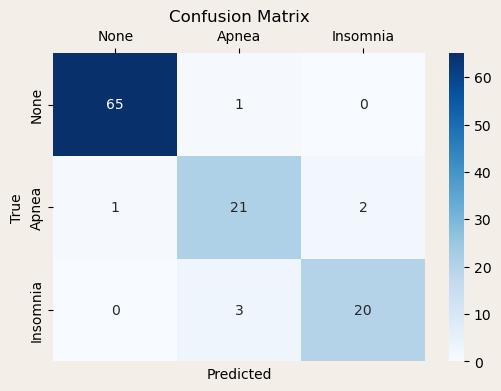

In [25]:
# Print test accuracy
pipeline_rf = grid_search_rf.best_estimator_
test_accuracy = pipeline_rf.score(X_test, y_test)
print('Test Accuracy:', settings.score_formatter(test_accuracy, 3))

# Generate prediction and show classification report
y_pred = pipeline_rf.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Model best at predicting None, with a very high precision and recall at 94%</li>
    <li>Apnea has lower recall at 79% (5 incorrect out of test 24 instances) and high precision (86%)</li>
    <li>Insomnia has high recall at 91% (2 incorrect out of 23 instances) and very similar precision to Apnea (86%)</li>
</ul>
</div>
